In [1]:
import os
import random
import cv2
from ultralytics import YOLO
import torch
import numpy as np
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp
import detectron2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from lang_sam import LangSAM    #pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git
from PIL import Image
from lang_sam.utils import draw_image


c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\groundingdino\models\GroundingDINO\ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [20]:
def GetYOLOResult_Contour(results):
    
    # Create a list to store dictionaries with area and count for each result
    result_data = []
    
    for result in results:
        areas = []
        image_shape = result.orig_shape
        overall_mask = np.zeros((result.orig_shape[0], result.orig_shape[1]), dtype=np.uint8)
        for j, mask in enumerate(result.masks.data):
        #   # Move the mask tensor to CPU if it's on a CUDA device
            mask_np = mask.detach().cpu().numpy() if isinstance(mask, torch.Tensor) else mask

        #   # Convert the mask to uint8 and resize it to match the image size
#            mask_np = cv2.resize((mask_np.astype( np.uint8) * 255), (result.orig_shape[1], result.orig_shape[0]))
 
            # Resize to original image size, Using INTER_NEAREST ensures resized mask remains binary with values 0 and 1, preserving its original nature. 
            mask_np_resized = cv2.resize(mask_np, (result.orig_shape[1], result.orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)
            
            contours, _ = cv2.findContours(mask_np_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize the total area for this mask
            total_area = 0.0
    
            # Iterate through each contour and calculate its area
            for contour in contours:
                area = cv2.contourArea(contour)
                total_area += area
            
            #area_covered = np.sum(mask_np_resized)
            areas.append(total_area)
            
            # Combine the current mask with the overall mask using logical OR operation
            overall_mask = cv2.bitwise_or(overall_mask, mask_np_resized)

        result_data.append({'area': sum(areas), 'count': len(areas), 'overallMask': overall_mask})
        
    return result_data  # get count of fibres and area covered


def GetYOLOResult(results):
    
    # Create a list to store dictionaries with area and count for each result
    result_data = []
    
    for result in results:
        areas = []
        image_shape = result.orig_shape
        overall_mask = np.zeros((result.orig_shape[0], result.orig_shape[1]), dtype=np.uint8)
        for j, mask in enumerate(result.masks.data):
        #   # Move the mask tensor to CPU if it's on a CUDA device
            mask_np = mask.detach().cpu().numpy() if isinstance(mask, torch.Tensor) else mask

        #   # Convert the mask to uint8 and resize it to match the image size
#            mask_np = cv2.resize((mask_np.astype( np.uint8) * 255), (result.orig_shape[1], result.orig_shape[0]))
 
            # Resize to original image size, Using INTER_NEAREST ensures resized mask remains binary with values 0 and 1, preserving its original nature. 
            mask_np_resized = cv2.resize(mask_np, (result.orig_shape[1], result.orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)
            
            area_covered = np.sum(mask_np_resized)
            areas.append(area_covered)
            
            # Combine the current mask with the overall mask using logical OR operation
            overall_mask = cv2.bitwise_or(overall_mask, mask_np_resized)

        result_data.append({'area': sum(areas), 'count': len(areas), 'overallMask': overall_mask})
        
    return result_data  # get count of fibres and area covered



def GetDetectronResult(results):
    
    # Create a list to store dictionaries with area and count for each result
    result_data = []
    
    
        # Access the predicted instances (bounding boxes, masks, etc.)
    #instances = outputs["instances"]

    # Access the predicted masks
    predicted_masks = results["instances"].pred_masks
    predicted_masks_np = predicted_masks.cpu().numpy()
    
    image_size = results["instances"].image_size
    height, width = image_size

    overall_mask = np.zeros((height, width), dtype=np.uint8)
    areas = []
    for i, mask in enumerate(predicted_masks_np):
        
    # Calculate the contour of the mask using cv2.findContours (only external contours)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Initialize the total area for this mask
        total_area = 0.0
        
        # Iterate through each contour and calculate its area
        for contour in contours:
            area = cv2.contourArea(contour)
            total_area += area

        areas.append(total_area)

        # Combine the current mask with the overall mask using logical OR operation
        overall_mask = cv2.bitwise_or(overall_mask, mask)

    result_data.append({'area': sum(areas), 'count': len(areas), 'overallMask': overall_mask})
        
    return result_data  # get count of fibres and area covered


def GetSAMresult(results):
    
    # Create a list to store dictionaries with area and count for each result
    result_data = []

    width = results[0]['crop_box'][2]          # Cropping is the same for all the image and so represents the size of the image
    height = results[0]['crop_box'][3]
    overall_mask = np.zeros((height, width), dtype=np.uint8)
    areas = []
    for i in range(1, len(results)):   # Ignore the first finding because that always seemsto be the entire shape
         
        results[i]['segmentation']
        # Move the mask tensor to CPU if it's on a CUDA device
        mask_np = results[i]['segmentation'].detach().cpu().numpy() if isinstance(results[i]['segmentation'], torch.Tensor) else results[i]['segmentation']
        areas.append(results[i]['area'])
            
        # Combine the current mask with the overall mask using logical OR operation
        #overall_mask = cv2.bitwise_or(overall_mask, mask_np)
        overall_mask[mask_np] = 1
    result_data.append({'area': sum(areas), 'count': len(results), 'overallMask': overall_mask})
        
    return result_data  # get count of fibres and area covered

def show_anns(anns):
    # for use when displaying segment anything mask 
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def overlay_mask_on_image(image, anns):
    if len(anns) == 0:
        return image

    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    img = image.copy()

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.random.rand(3)  # Random color for the mask
        img[m] = img[m] * 0.3 + color_mask * 0.7  # Blend the mask with the image

    return img


def prep_mask_image(anns):
    if len(anns) == 0:
        return None
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    img = (img * 255).astype(np.uint8)  # Convert to uint8 range (0-255)
    return Image.fromarray(img)




def calculate_iou(groundTruth, predicted):
    intersection = np.logical_and(groundTruth, predicted).sum()
    union = np.logical_or(groundTruth, predicted).sum()
    iou = intersection / union
    
    dice_coefficient = 2 * np.sum(intersection) / (np.sum(groundTruth) + np.sum(predicted))
    return iou , dice_coefficient



In [21]:
 # train on the GPU or on the CPU, if a GPU is not available - CPU will be very slow
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# Source Data
fibre_images = r'C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images'
fibre_masks = r'C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks'
img_files = os.listdir(fibre_images) # Get list of files in the directory 

##########################################################################################
# YOLO Model
##########################################################################################
preTrainedYOLO = r'C:\Users\dezos\Documents\Fibres\FibreAnalysis\YoloLTrain1.pt'
# Load a model
YOLOmodel = YOLO(preTrainedYOLO)  # pretrained YOLOv8n model

##########################################################################################
# Detectron 
##########################################################################################
cfg = get_cfg()

#cfg.MODEL.DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cfg.MODEL.DEVICE = device.type
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
###
####### Change this 

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = r'C:\Users\dezos\Documents\Fibres\FibreAnalysis\Detectron2_Trained_Model.pth'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Model was trained on one class so need to specify that here 
##
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
Detect2Predictor = DefaultPredictor(cfg)

##########################################################################################
# Segment Anything 
##########################################################################################

sam_checkpoint = r"C:\Users\dezos\Documents\Fibres\FibreAnalysis\sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = device

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

sam_mask_generator = SamAutomaticMaskGenerator(sam)

###########################################################################################
# Language Segment anything 
###########################################################################################

samL = LangSAM()




cpu
final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from C:\Users\dezos\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-41-07-439885_1.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks\mask_2023-07-24_19-41-07-439885_1.png


image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-41-07-439885_1.png: 640x512 6 fibres, 998.8ms
Speed: 3.0ms preprocess, 998.8ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-41-07-439885_1.png: 640x512 6 fibres, 944.1ms
Speed: 4.5ms preprocess, 944.1ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-41-07-439885_1.png: 640x512 6 fibres, 895.2ms
Speed: 2.0ms preprocess, 895.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 512)
c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\transformers\modeling_utils.py:874: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\dezos\Documents\Fibres\FibreAnal

sam lables ['line', 'line', 'line', 'line', 'line', 'line']
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-40-08-534942_1.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks\mask_2023-07-24_19-40-08-534942_1.png


image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-40-08-534942_1.png: 640x544 7 fibres, 1430.7ms
Speed: 4.0ms preprocess, 1430.7ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-40-08-534942_1.png: 640x544 7 fibres, 1154.4ms
Speed: 6.9ms preprocess, 1154.4ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-40-08-534942_1.png: 640x544 7 fibres, 1110.2ms
Speed: 5.0ms preprocess, 1110.2ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 544)
c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\transformers\modeling_utils.py:874: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\dezos\Documents\Fibres\F

sam lables ['line', 'line', 'line', 'line', 'line']
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-36-888733_1.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks\mask_2023-07-24_19-39-36-888733_1.png


image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-36-888733_1.png: 448x640 3 fibres, 969.7ms
Speed: 2.0ms preprocess, 969.7ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-36-888733_1.png: 448x640 3 fibres, 978.0ms
Speed: 3.0ms preprocess, 978.0ms inference, 5.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-36-888733_1.png: 448x640 3 fibres, 1047.9ms
Speed: 3.0ms preprocess, 1047.9ms inference, 5.9ms postprocess per image at shape (1, 3, 448, 640)
c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\transformers\modeling_utils.py:874: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\dezos\Documents\Fibres\FibreAn

sam lables ['line', '', '', '', '', '']
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-57-881380_1.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks\mask_2023-07-24_19-39-57-881380_1.png


image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-57-881380_1.png: 640x480 4 fibres, 1017.1ms
Speed: 3.3ms preprocess, 1017.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-57-881380_1.png: 640x480 4 fibres, 962.2ms
Speed: 2.0ms preprocess, 962.2ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-57-881380_1.png: 640x480 4 fibres, 978.3ms
Speed: 3.0ms preprocess, 978.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)
c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\transformers\modeling_utils.py:874: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\dezos\Documents\Fibres\FibreAn

sam lables ['line']
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-20-595722_2.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks\mask_2023-07-24_19-39-20-595722_2.png


image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-20-595722_2.png: 448x640 2 fibres, 914.6ms
Speed: 2.5ms preprocess, 914.6ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-20-595722_2.png: 448x640 2 fibres, 892.1ms
Speed: 3.0ms preprocess, 892.1ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-39-20-595722_2.png: 448x640 2 fibres, 900.1ms
Speed: 2.5ms preprocess, 900.1ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)
c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\transformers\modeling_utils.py:874: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\dezos\Documents\Fibres\FibreAnal

sam lables ['line', 'line', '', 'line', 'line', '', 'line', '']


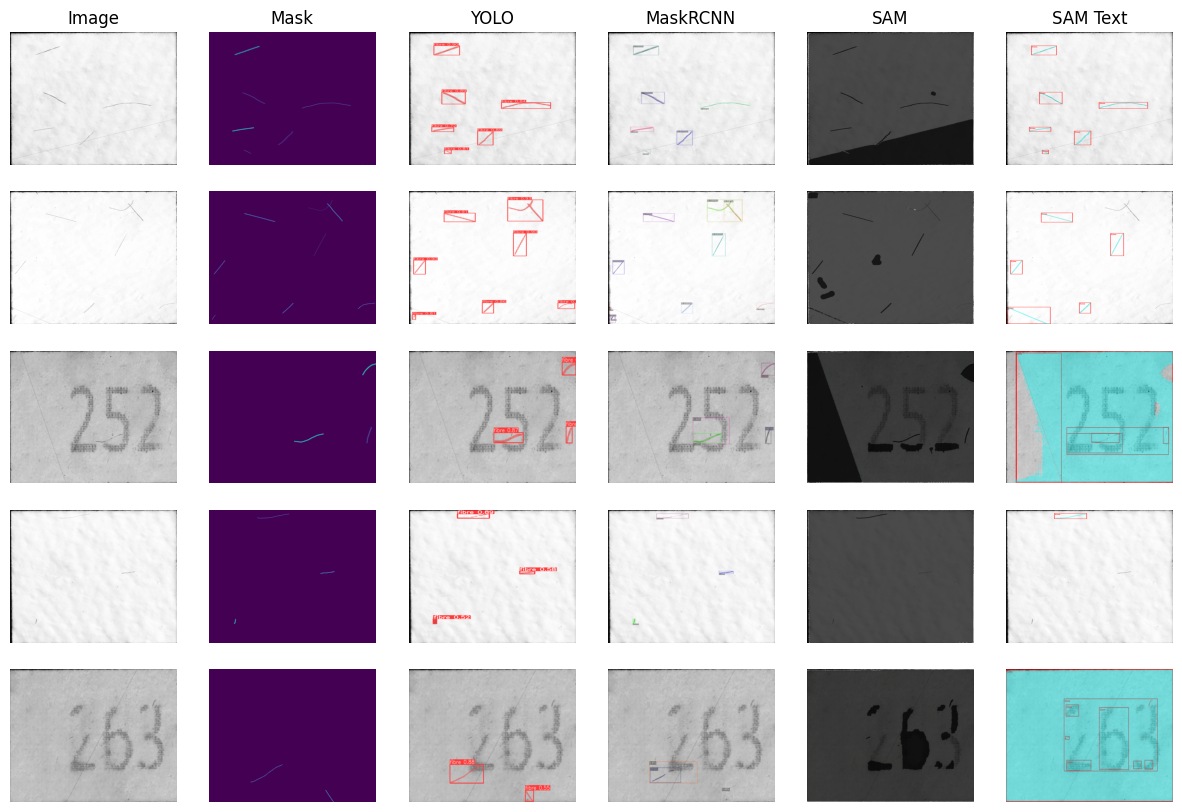

In [27]:
dataHolder = []
# Create a new figure
fig, axes = plt.subplots(5, 6, figsize=(15, 10))

# Set individual titles for each column
axes[0, 0].set_title("Image")
axes[0, 1].set_title("Mask")
axes[0, 2].set_title("YOLO")
axes[0, 3].set_title("MaskRCNN")
axes[0, 4].set_title("SAM")
axes[0, 5].set_title("SAM Text")

for i, d in enumerate(random.sample(img_files, 5)):    
    fullPath = os.path.join(fibre_images, d)
    mask_path = os.path.join(fibre_masks, f"mask{d[5:]}")  # Change filename from image_ to mask _ to retrieve mask
    print(fullPath)  # Print File name 
    print(mask_path)  # Print File name 
    image = cv2.imread(fullPath)  # Load your input image   
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
    # Image
    ax = axes[i , 0]
    ax.imshow(image)
    ax.axis('off')
    ax.set_aspect('auto')    
    
    #Mask
    ax = axes[i , 1]
    ax.imshow(ground_truth_mask)
    ax.axis('off')
    ax.set_aspect('auto')    
    
    # YOLO
    results = YOLOmodel(fullPath)
    YOLOresult = GetYOLOResult_Contour(YOLOmodel(fullPath))   # get area and count for YOLO    
    yoloImage = YOLOmodel(fullPath)
    res_plotted = yoloImage[0].plot()
    res_plotted_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
    ax = axes[i , 2]
    ax.imshow(res_plotted_rgb)
    ax.axis('off')
    ax.set_aspect('auto')    
   
    # Mask RCNN 
    result_detectron = Detect2Predictor(image)
# Create a Visualizer and draw the instance predictions
    v = Visualizer(image[:, :, ::-1], scale=1.2)  # Remove the metadata argument
    out = v.draw_instance_predictions(result_detectron["instances"].to("cpu"))

    # Convert the output to BGR format before displaying using cv2
    visualized_output = out.get_image()[:, :, ::-1]

    # Resize the visualized output to match the size of the input image
    visualized_output = cv2.resize(visualized_output, (image.shape[1], image.shape[0]))

    # Overlay predicted masks on the original image
    combined_image = cv2.addWeighted(image, 0.5, visualized_output, 0.5, 0)

    # Display the combined image on the specified subplot (ax)
    ax = axes[i , 3]
    ax.imshow(combined_image)
    ax.axis('off')
    ax.set_aspect('auto')    

    # SAM 
    SAMmasks = sam_mask_generator.generate(image)

    SAMresults = GetSAMresult(SAMmasks)
    SAM_Image = overlay_mask_on_image(image, SAMmasks )
    ax = axes[i , 4]
    ax.imshow(SAM_Image)
    ax.axis('off')
    ax.set_aspect('auto')    
        
    # SAM Language
    mask_image = prep_mask_image(SAMmasks)
    grayscale_image = mask_image.convert("L")
    # Create a new RGB image with grayscale values in all channels
    rgb_bw_image = Image.new("RGB", grayscale_image.size)
    rgb_bw_image.paste(grayscale_image)
    text_prompt = "line"
    SAMLmasks, SAMLboxes, SAMLlabels, SAMLlogits = samL.predict(rgb_bw_image, text_prompt, box_threshold=0.20, text_threshold=0.24)

    print('sam lables', SAMLlabels)
    image_array = np.array(image)
    image101 = draw_image(image_array,  SAMLmasks,  SAMLboxes,  SAMLlabels)
 
    ax = axes[i , 5]
    ax.imshow(image101)
    ax.axis('off')
    ax.set_aspect('auto')    
 
 
    # plt.figure(figsize=(20,20))
    # plt.imshow(image101)

    # plt.axis('off')
plt.show()


In [5]:
len(img_files)

291

In [7]:
for i, d in enumerate(random.sample(img_files, 2)):    
    fullPath = os.path.join(fibre_images, d)
    mask_path = os.path.join(fibre_masks, f"mask{d[5:]}")  # Change filename from image_ to mask _ to retrieve mask
    print(fullPath)  # Print File name 
    print(mask_path)  # Print File name 
    image = cv2.imread(fullPath)  # Load your input image   
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    ax = axes[i , 1]
    ax.imshow(image)
    ax.axis('off')
    ax = axes[i , 2]
    ax.imshow(ground_truth_mask)
    ax.axis('off')

plt.show()    
#    results = YOLOmodel(fullPath)
    # cv2.imshow("result", image)             #https://docs.ultralytics.com/modes/predict/#plotting-results
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()  

    # YOLOresult = GetYOLOResult_Contour(YOLOmodel(fullPath))   # get area and count for YOLO    
   
    # yoloImage = YOLOmodel(fullPath)
    # res_plotted = yoloImage[0].plot()
    # res_plotted_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)


    # ax = axes[i , 2]
    # ax.imshow(res_plotted_rgb)
    # ax.axis('off')
    # plt.show()
   
    # # result_11111 = Detect2Predictor(image)
   
    # # DetectronResult = GetDetectronResult(Detect2Predictor(image))

    # SAMmasks = sam_mask_generator.generate(image)

    # SAMresults = GetSAMresult(SAMmasks)
    
    
    # # Language
    # mask_image = prep_mask_image(SAMmasks)

    # grayscale_image = mask_image.convert("L")

    # # Create a new RGB image with grayscale values in all channels
    # rgb_bw_image = Image.new("RGB", grayscale_image.size)
    # rgb_bw_image.paste(grayscale_image)
    # text_prompt = "line"

    # SAMLmasks, SAMLboxes, SAMLlabels, SAMLlogits = samL.predict(rgb_bw_image, text_prompt, box_threshold=0.20, text_threshold=0.24)

    # image_array = np.array(image)
    # image101 = draw_image(image_array,  SAMLmasks,  SAMLboxes,  SAMLlabels)
    # plt.figure(figsize=(20,20))
    # plt.imshow(image101)

    # plt.axis('off')
    # plt.show()


   # Calculate IoU and Dice coefficient
#    iou_value, diceCoef= calculate_iou(ground_truth_mask, YOLOresult[-1]["overallMask"])
#    iou_value_detect, diceCoef_detect= calculate_iou(ground_truth_mask, DetectronResult[-1]["overallMask"])
    #iou_value_SAM, diceCoef_SAM= calculate_iou(ground_truth_mask, SAMresults[-1]["overallMask"])    
    
   # Prepare rows for dataframe later. See this link as to why to create a list first (much faster)  https://stackoverflow.com/questions/10715965/create-a-pandas-dataframe-by-appending-one-row-at-a-time
#     dataHolder.append([d, iou_value, diceCoef, iou_value_detect, diceCoef_detect])
    
#     print("IoU:", iou_value)
#     print("Dice Coefficient:", diceCoef)

#     # YOLO 
# #Display the image with full markup 
# #   res_plotted = results[0].plot()  # assuming only one image per run 


# plt.tight_layout()
# plt.show()

C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-41-50-208736_2.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks\mask_2023-07-24_19-41-50-208736_2.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\images\image_2023-07-24_19-38-31-496795_2.png
C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\Prepared\Test\masks\mask_2023-07-24_19-38-31-496795_2.png
